In [112]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler
import time


SEQ_LEN=720
OUTPUT_LEN=60
EPOCHS=2
STEPS_PER_EPOCH=100
BATCH_SIZE=256
TARGET_VALUE="close"
sequence_length = 60
shift_steps=10
warmup_steps = 50

In [113]:
# url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
url = "./datasets/eurusd-m15-2018/EURUSD.csv"
df = pd.read_csv(url)
df.drop("Volume", 1, inplace=True)
df.drop("Date", 1, inplace=True)
df.drop("Timestamp", 1, inplace=True)

df.head()

,open,high,low,close
date,,,,
2018-01-01 17:00:00,1.20037,1.20100,1.20037,1.20100
2018-01-01 17:01:00,1.20083,1.20095,1.20017,1.20030
2018-01-01 17:02:00,1.20035,1.20043,1.20035,1.20043
2018-01-01 17:03:00,1.20041,1.20050,1.20031,1.20046
2018-01-01 17:04:00,1.20049,1.20049,1.20046,1.20048


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb32e1bbd0>,
      dtype=object)

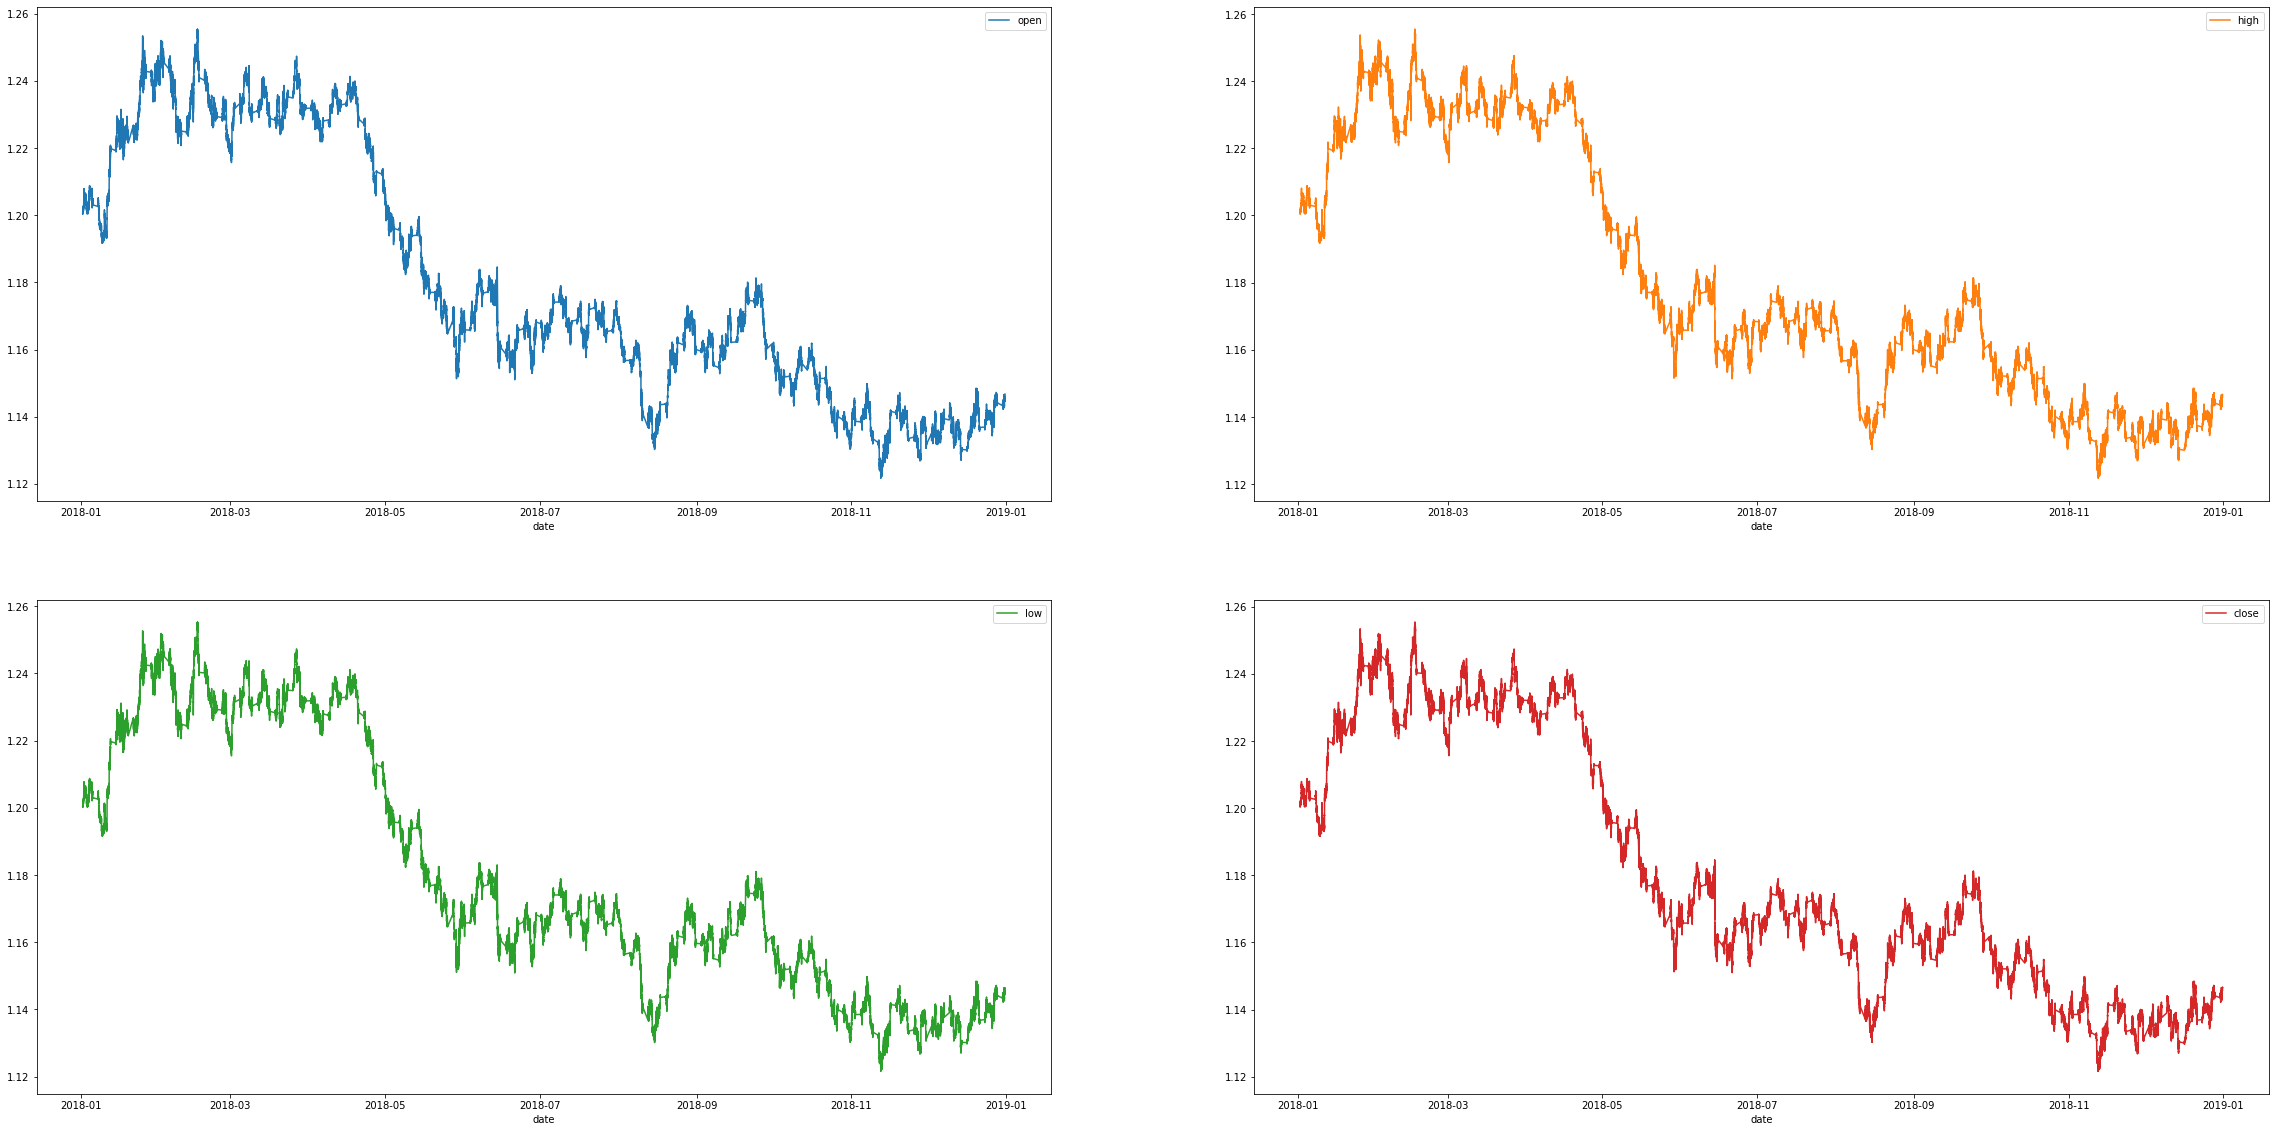

In [114]:
df.plot(subplots=True, layout=(2, 2), figsize=(40, 20), sharex=False)

In [115]:
data_set = df.iloc[:, 2:3].values #close
print(data_set)

[[1.20037]
 [1.20017]
 [1.20035]
 ...
 [1.1464 ]
 [1.14639]
 [1.14635]]


In [116]:
print(data_set.shape)

(372607, 1)


In [117]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(data_set)
training_set_scaled.size

372607

In [118]:
X_train = []
y_train = []
for i in range(SEQ_LEN, training_set_scaled.size-OUTPUT_LEN):
    X_train.append(training_set_scaled[i-SEQ_LEN:i, 0])
    y_train.append(np.array(training_set_scaled[i:i+OUTPUT_LEN, 0]))
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[0])
print(y_train[0])

[0.58947132 0.58797577 0.58932177 0.58902266 0.59014432 0.59029388
 0.58909744 0.58872355 0.5902191  0.59238765 0.59238765 0.59298587
 0.59261198 0.59268676 0.59246242 0.58939655 0.5895461  0.5895461
 0.58969566 0.58977043 0.58999477 0.59006954 0.59006954 0.59029388
 0.59006954 0.59051821 0.58984521 0.58984521 0.59149032 0.59141554
 0.59178943 0.59193898 0.59238765 0.59193898 0.59328498 0.59590219
 0.59635086 0.59635086 0.59664997 0.59650041 0.59657519 0.59664997
 0.5968743  0.59672474 0.59664997 0.59672474 0.59672474 0.59777163
 0.59650041 0.59657519 0.59664997 0.59664997 0.59664997 0.59679952
 0.59702385 0.59724819 0.59709863 0.59709863 0.5968743  0.59522919
 0.59051821 0.5882001  0.59051821 0.59178943 0.59201376 0.5918642
 0.5925372  0.59223809 0.59238765 0.5932102  0.5932102  0.59283631
 0.5932102  0.59612652 0.59717341 0.59747252 0.59709863 0.59709863
 0.59694908 0.59679952 0.59433186 0.5938832  0.59575264 0.59560308
 0.59530397 0.59507964 0.59500486 0.59545353 0.59657519 0.596350

In [119]:
X_train = np.reshape(np.asarray(X_train).astype(np.float32), (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(371827, 720, 1)


In [120]:
print(y_train[0])

[0.63845061 0.63725417 0.63710461 0.63934794 0.63830105 0.63740372
 0.63673073 0.63702984 0.6374785  0.63717939 0.63740372 0.63710461
 0.63650639 0.63501084 0.63493607 0.63351529 0.63373962 0.63411351
 0.63246841 0.63261796 0.63276752 0.63351529 0.63486129 0.63530995
 0.63650639 0.63702984 0.63807672 0.63770283 0.63957227 0.64024527
 0.64069394 0.64316159 0.64293726 0.64211471 0.64218949 0.64301204
 0.6418156  0.63994616 0.63957227 0.64017049 0.64196515 0.6448067
 0.64443281 0.6448067  0.64450759 0.64241382 0.64196515 0.64211471
 0.64017049 0.63942272 0.63860016 0.63860016 0.63860016 0.6388245
 0.63830105 0.63650639 0.63755328 0.63785239 0.63740372 0.63710461]


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [122]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(297461, 720, 1)
(74366, 720, 1)
(297461, 60)
(74366, 60)


In [138]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    
    print(y_true, y_pred)
    
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:]
    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [143]:
model = Sequential()

model.add(GRU(units=512,input_shape=(None, 1)))
init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(sequence_length, activation='linear', kernel_initializer=init))

# opt = Adam(lr=0.001, decay=1e-6)

NAME = f"PRED-{int(time.time())}-OUTPUT_LEN={OUTPUT_LEN}-SEQ_LEN={SEQ_LEN}"  
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME, update_freq=25))
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.0001)


def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    return lr / (epoch*3)  

lr_scheduler_cb=LearningRateScheduler(schedule=scheduler)

optimizer = RMSprop(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 64)                12864     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


In [144]:

model.fit(X_train,y_train,epochs=EPOCHS,batch_size=256,validation_data=(X_test, y_test), callbacks=[tensorboard])

model_file=f"models/{NAME}_model.h5"

model.save(model_file)

score=model.evaluate(X_test, y_test, verbose=1) 

Epoch 1/2
1162/1162 [==============================] - 546s 470ms/step - loss: 0.0025 - val_loss: 4.0592e-04
Epoch 2/2
2324/2324 [==============================] - 95s 41ms/step - loss: 9.4851e-05


In [ ]:
print(NAME)

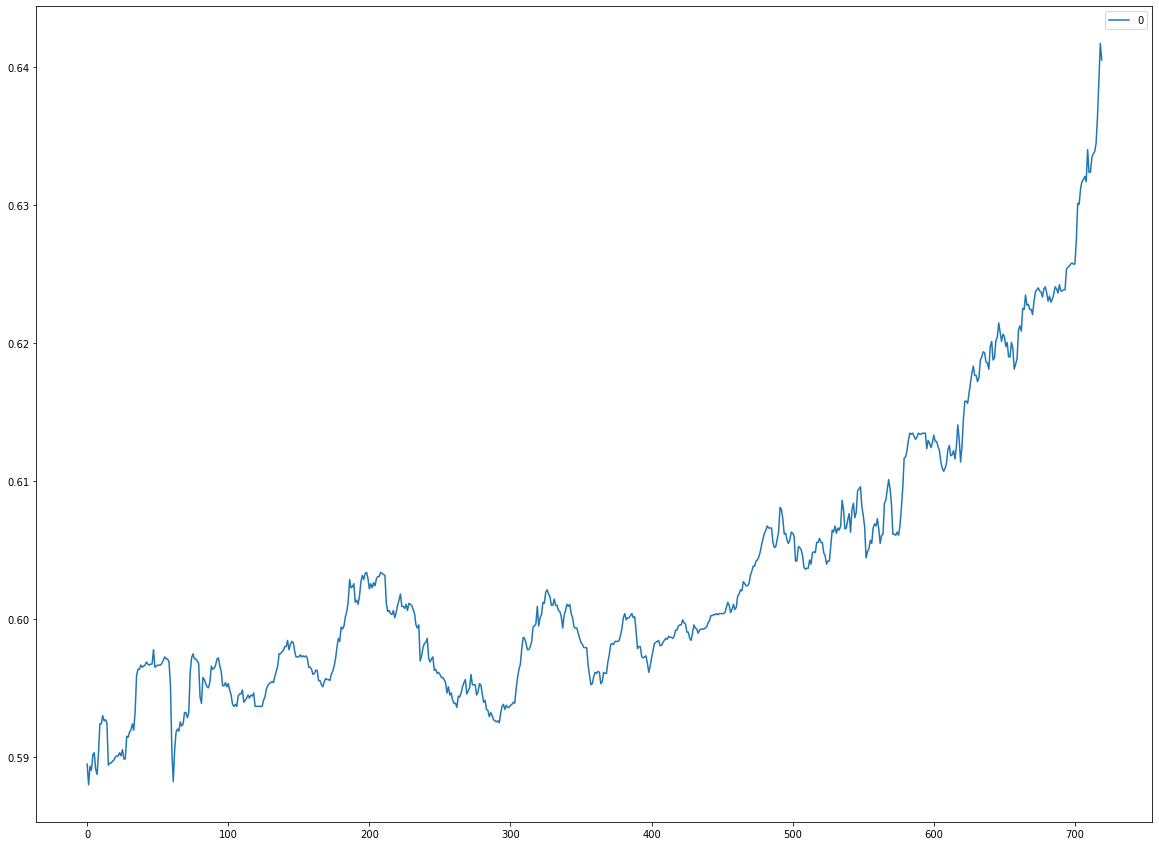

In [149]:
chain_predict = np.array([training_set_scaled[:SEQ_LEN]])
pd.DataFrame(data=chain_predict[0]).plot(figsize=(20, 15), )

In [150]:
output=[]

for i in range(SEQ_LEN,5000):
    if i%100==0 or i==SEQ_LEN:
        print(i/5000*100)
    pred_val=model.predict(chain_predict)
    output.append(pred_val)
    concatenated=np.concatenate((np.array([x[0] for x in chain_predict[0][:SEQ_LEN-OUTPUT_LEN]]), pred_val[0]))
    chain_predict=np.array([concatenated.reshape(-1,1)])

14.399999999999999
16.0
18.0
20.0
22.0
24.0
26.0
28.000000000000004
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.00000000000001
57.99999999999999
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0


In [155]:
print(model.predict(chain_predict))
print()
print(np.array([x[0] for x in output]).flatten())
output=np.array([x[0] for x in output]).flatten()

[[0.60555]]



IndexError: invalid index to scalar variable.

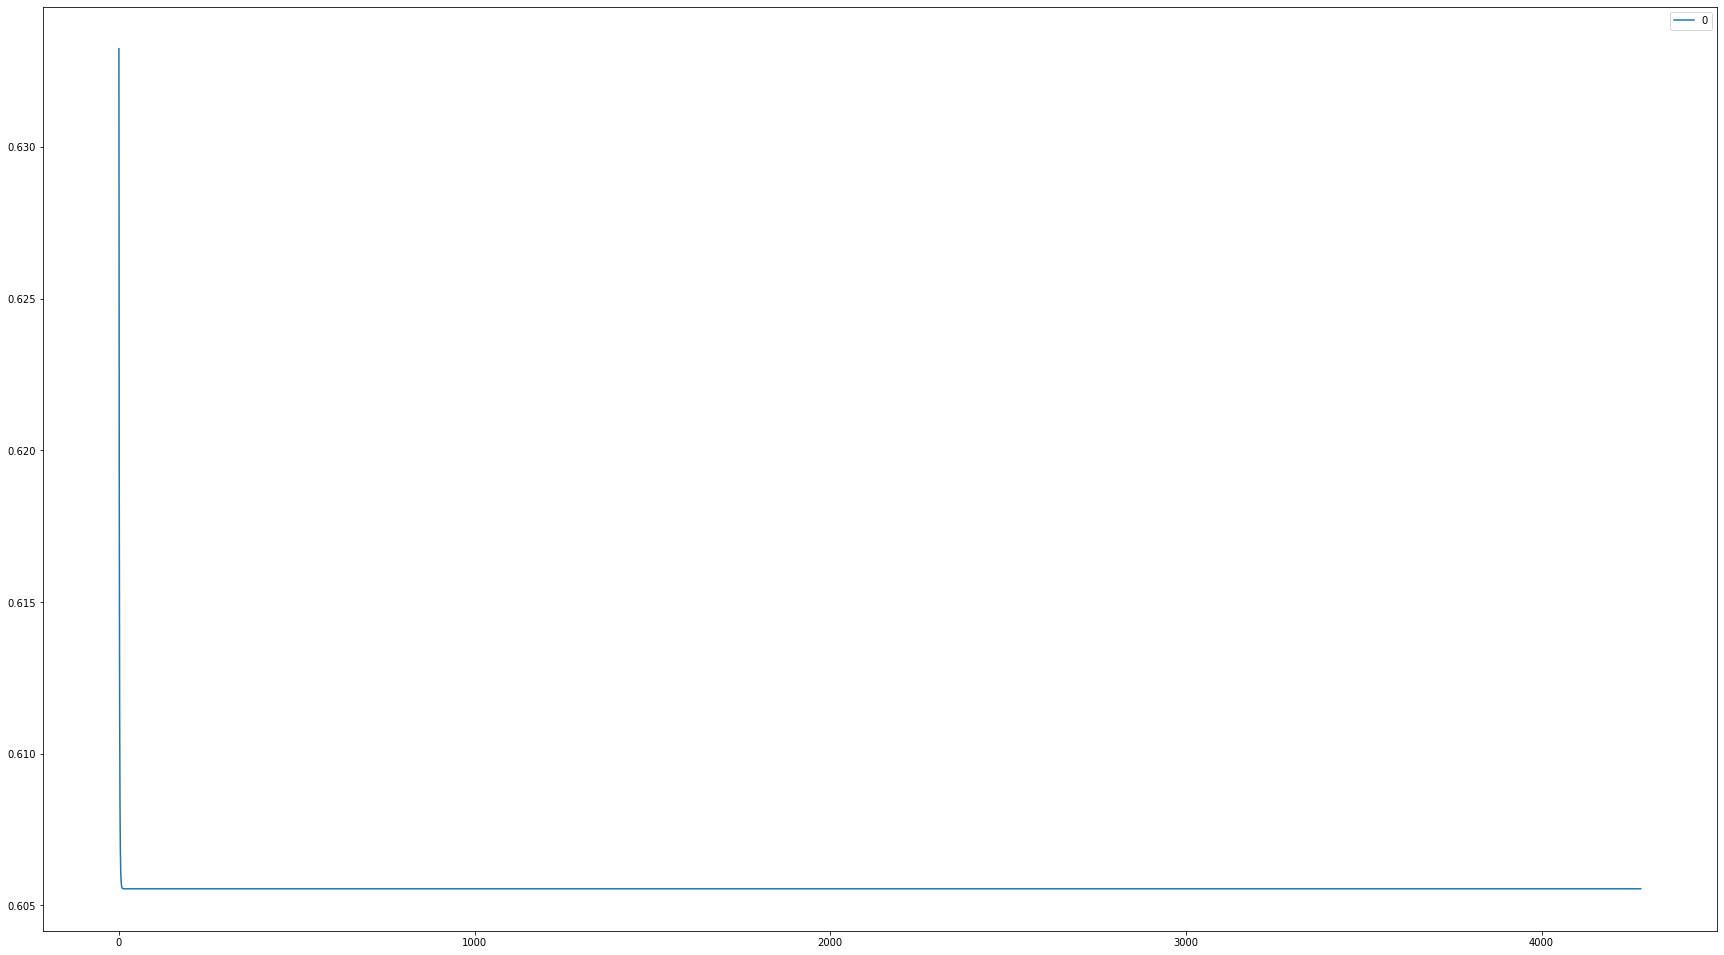

In [152]:
npoutput=sc.inverse_transform(np.array(output).reshape(-1,1))
npoutput=np.array(output).reshape(1,-1)[0]


pd.DataFrame(data=npoutput).plot(figsize=(30, 17))

In [156]:
print(npoutput)

[0.6332362  0.6184935  0.61160123 ... 0.60555    0.60555    0.60555   ]


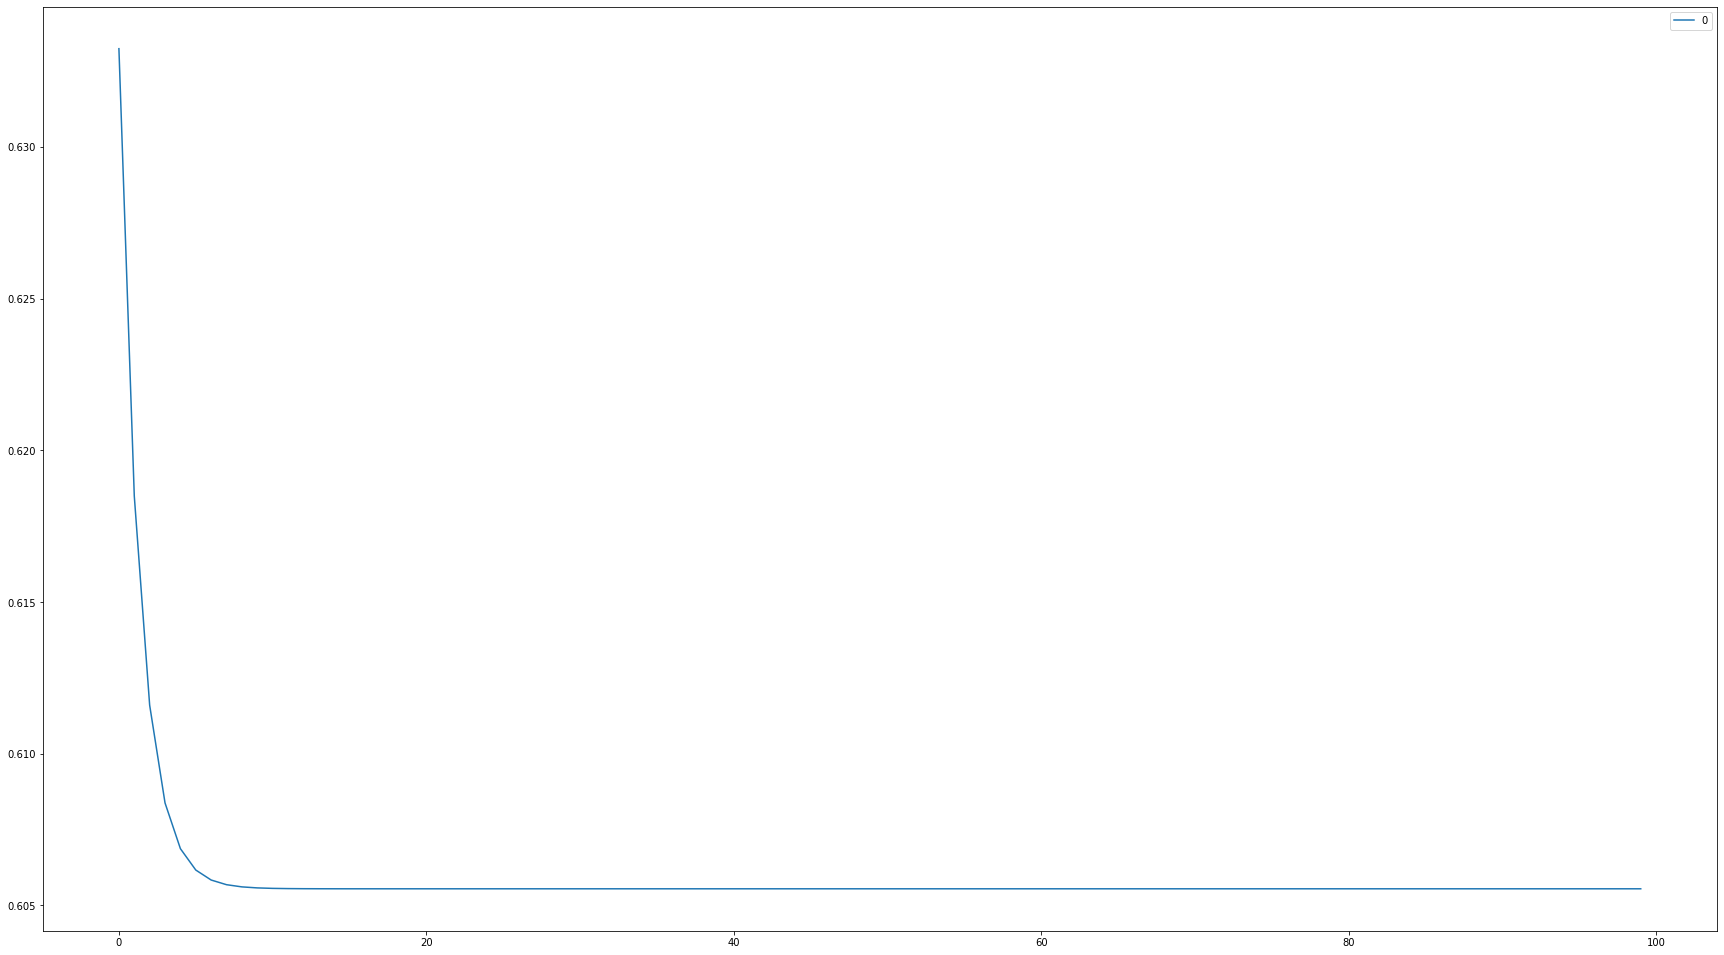

In [157]:
pd.DataFrame(data=npoutput[:100]).plot(figsize=(30, 17))

In [158]:
ytst=model.predict(np.array([X_test[0]]))

In [159]:
y_tst_np=np.array(y_test[0])
xtest_np=np.array([x[0] for x in X_test[0]])
print(xtest_np)
cont=np.concatenate((xtest_np,y_tst_np ))
print(cont.shape)

[0.3694758  0.3692515  0.36999926 0.37007403 0.37007403 0.3699245
 0.3698497  0.36902714 0.3694758  0.3691019  0.3691767  0.36842892
 0.36865327 0.36880282 0.36880282 0.36842892 0.3685037  0.36798027
 0.36835414 0.36835414 0.36798027 0.36835414 0.36827937 0.3678307
 0.3675316  0.3671577  0.36678383 0.3668586  0.3668586  0.3675316
 0.36768115 0.36775592 0.36805505 0.36760637 0.36760637 0.3675316
 0.36760637 0.36768115 0.36768115 0.3685037  0.36835414 0.36842892
 0.3688776  0.3695506  0.3694758  0.36940104 0.3695506  0.3694758
 0.3691767  0.36902714 0.36865327 0.3685785  0.3695506  0.36962536
 0.36940104 0.36902714 0.36902714 0.3694758  0.3695506  0.3691767
 0.36940104 0.3694758  0.3699245  0.37022358 0.3699245  0.36970013
 0.36970013 0.3697749  0.3691019  0.36902714 0.3691019  0.36895236
 0.36872804 0.3685785  0.3691019  0.36790547 0.36798027 0.36835414
 0.3688776  0.36827937 0.36842892 0.36827937 0.36895236 0.36835414
 0.3685785  0.3685785  0.36798027 0.36798027 0.36827937 0.36842892
 

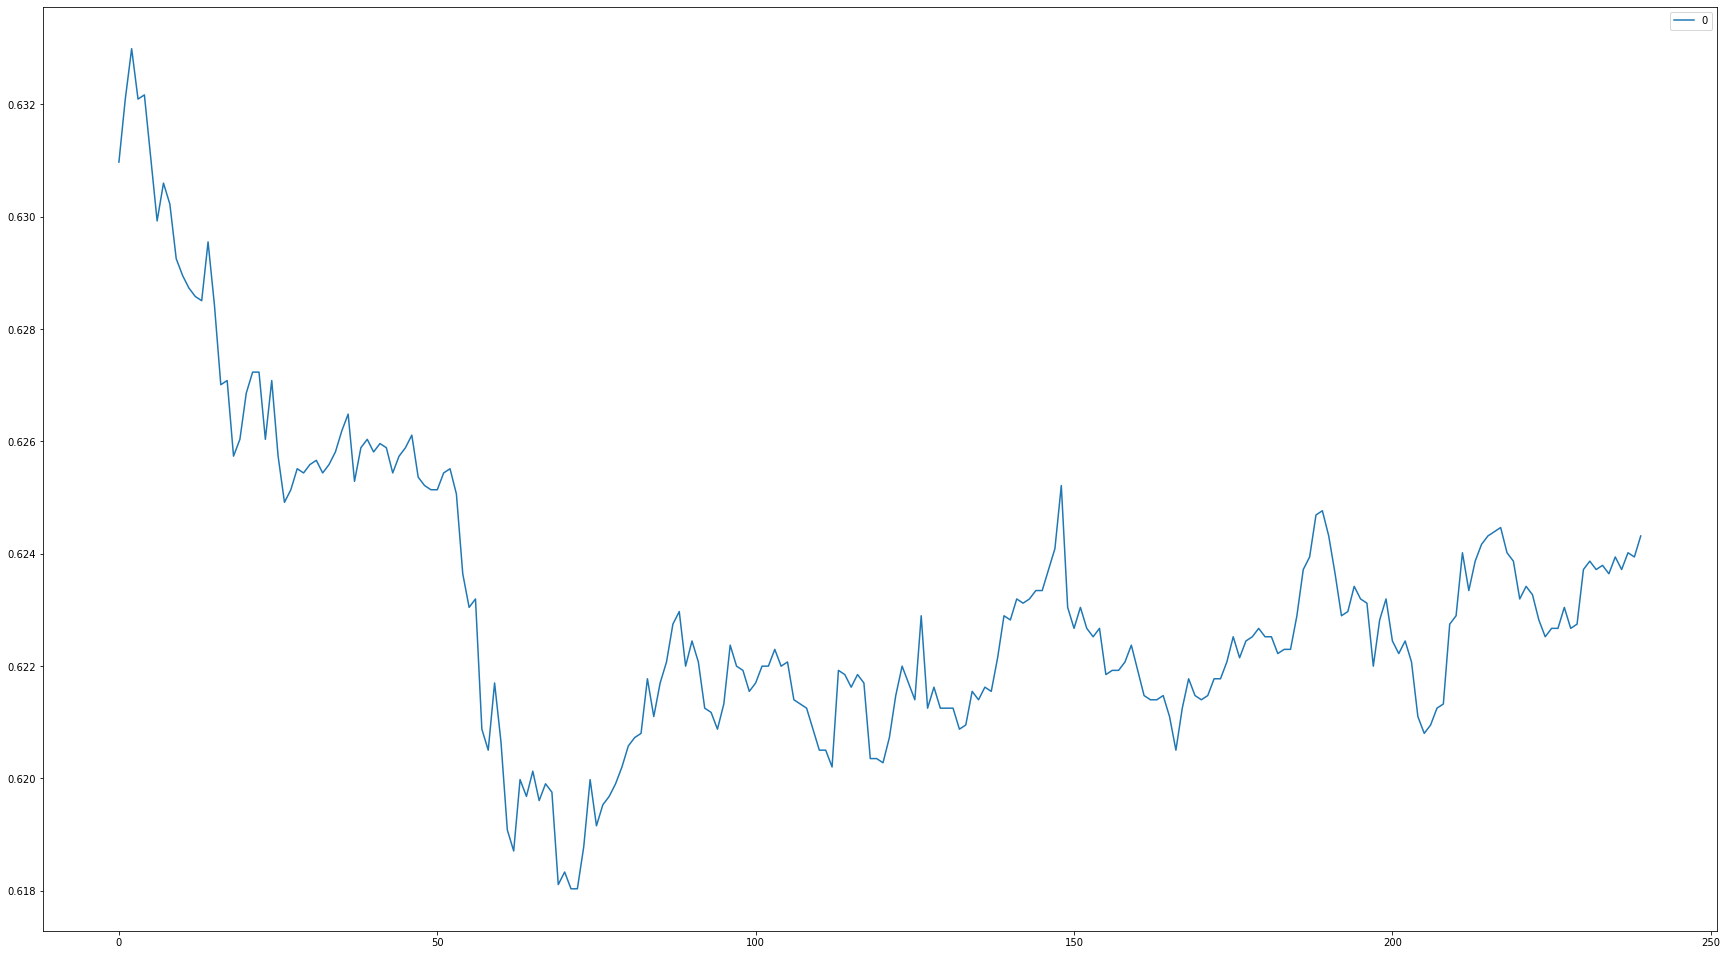

In [101]:
pd.DataFrame(data=cont).plot(figsize=(30, 17))

In [102]:
# X_train, X_test, y_train, y_test

